# Observed Influence Model

This notebook is intended to roughly replicate the Observed Influence Model results from Sumit Basu, Tanzeem Choudhury,
Brian Clarkson, and Alex Pentland. "Learning Human Interactions with the Influence Model."  MIT Media Laboratory Vision
and Modeling Technical Report #539. June, 2001.

We will set a random seed to ensure the results from this notebook are deterministic.

In [1]:
import random

random.seed(825)

## Training Sequence

We begin by defining an influence model that we will use to produce a training sequence, as in Basu et al. (2001).

> The data was generated by an Influence Model with 3 chains in lock step: one leader which was evolving randomly (i.e.,
flat transition tables) and 2 followers who meticulously followed the leader (i.e., an influence of 1 by chain 2 and a
self-influence of 0). We sampled this model to obtain a training sequence of 50 timesteps for each chain.

### Sites

We initialize three sites - one leader and two followers. The initial state $s[0]$ is independently realized from
some given distribution and here we are arbitrarily setting the initial status of each site. There are $n$ sites and, in
this example, each site has the same number of possible statuses, $m$ (though this is not required).

In [2]:
import numpy as np

from influence.site import Site

follower_1 = Site('follower_1', np.array([[0], [0], [1]]))
leader = Site('leader', np.array([[1], [0], [0]]))
follower_2 = Site('follower_2', np.array([[0], [1], [0]]))
sites = [follower_1, leader, follower_2]

### Network Influence Model

We then define the network influence matrix $D$. In this example, we assume a leader who is evolving randomly and two
followers who exactly follow the leader (an influence of 1 exerted by the leader and a self-influence of 0). $D$ is a
stochastic matrix with dimension $n$ x $n$.

In [3]:
D = np.array([
    [0.0, 1.0, 0.0],  # follower 1
    [0.0, 1.0, 0.0],  # leader
    [0.0, 1.0, 0.0],  # follower 2
])

### State-Transition Matrices

Finally, we define the state-transition matrices for each pair of sites $i$ and $j$. For each pair of sites $i$ and $j$,
the state-transition matrix $A_{ij}$ is an $m_i$ x $m_j$ nonnegative matrix whose rows sum to 1. In this example, we
use a flat transition table for all pairs of sites $i$ and $j$ that do not include the leader (the actual values within
$A$ for these pairs are irrelevant given the followers have a self-influence of 0). We also use a flat transition table
for the leader because it is evolving randomly. The pairs of sites that include the leader are identity matrices because
the followers always mimic the status of the leader (influence of 1).

In [4]:
state_transition_matrices = {
    (0,0): np.full((3, 3), 1./3),
    (0,1): np.full((3, 3), 1./3),
    (0,2): np.full((3, 3), 1./3),
    (1,0): np.eye(3),
    (1,1): np.full((3, 3), 1./3),
    (1,2): np.eye(3),
    (2,0): np.full((3, 3), 1./3),
    (2,1): np.full((3, 3), 1./3),
    (2,2): np.full((3, 3), 1./3),
}
A = np.array([
    [.5, .5, 1., 0.],
    [.5, .5, 0., 1.],
    [.5, .5, .5, .5],
    [.5, .5, .5, .5],
])

### Influence Model

We now define the influence model.

In [5]:
from influence.influence_model import InfluenceModel

model = InfluenceModel(sites, D, state_transition_matrices)

From this influence model, we will generate a sequence of state observations to use as a training sequence. The
influence process is the sequence of random state vectors $\textbf{s}[k]$ generated by the influence model as a result of
applying its evolution equations

\begin{aligned}
    \mathbf{p}'[k+1] &\overset{\Delta}{=} \mathbf{s}'[k]H \\
    \mathbf{s}'[k+1] &\overset{\Delta}{=} MultiRealize(\mathbf{p}'[k+1])
\end{aligned}


In [6]:
NUM_TIMESTEPS = 500

states = []
n = len(model.sites)
observations = {i: [] for i in range(n)}
for _ in range(NUM_TIMESTEPS):
    state = np.transpose(model.get_state_vector())
    states.append(state)
    for i, site in enumerate(model.sites):
        idx_arr = np.where(np.transpose(site.s)[0] == 1)
        status = idx_arr[0][0]
        observations[i].append(status)
    next(model)

The following shows a plot of the sequence of statuses for each site.

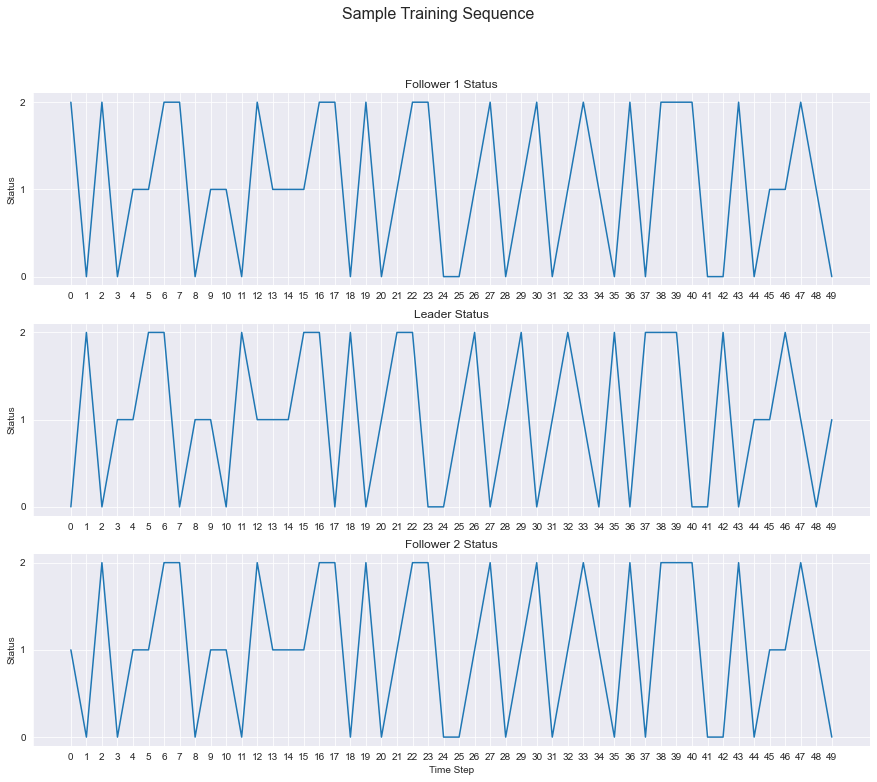

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

NUM_TIMESTEPS_TO_PLOT = 50

fig, ax = plt.subplots(3, 1, figsize=(15, 12))

ax[0].plot(observations[0][:NUM_TIMESTEPS_TO_PLOT])
ax[0].set_title('Follower 1 Status')

ax[1].plot(observations[1][:NUM_TIMESTEPS_TO_PLOT])
ax[1].set_title('Leader Status')

ax[2].plot(observations[2][:NUM_TIMESTEPS_TO_PLOT])
ax[2].set_title('Follower 2 Status')

fig.suptitle('Sample Training Sequence', fontsize=16)
plt.xlabel('Time Step')
plt.setp(ax, xticks=range(NUM_TIMESTEPS_TO_PLOT), ylabel='Status', yticks=[0, 1, 2])
sns.despine()

## Learning for the Influence Model

Our goal is to estimate the influence model from the training sequence generated above.

### State-Transition Matrices

We will first aim to reconstruct the state-transition matrices $\{A_{ij}\}$ via a maximum-likelihood estimate.

In [9]:
import itertools

from influence.learning import learn_state_transition_matrix

A_map = {}
site_permutations = list(itertools.permutations(range(n), 2))
more_permutations = [(i,i) for i in range(n)]
site_permutations.extend(more_permutations)
for (i,j) in site_permutations:
    A = learn_state_transition_matrix(observations[i], observations[j], 3, 3)
    A_map[(i,j)] = A
    print(i, j)
    print(A)

0 1
[[0.33333333 0.32692308 0.33974359]
 [0.2804878  0.33536585 0.38414634]
 [0.32402235 0.32960894 0.34636872]]
0 2
[[0.30128205 0.35897436 0.33974359]
 [0.27439024 0.3597561  0.36585366]
 [0.3575419  0.27932961 0.36312849]]
1 0
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
1 2
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
2 0
[[0.30128205 0.35897436 0.33974359]
 [0.27878788 0.35757576 0.36363636]
 [0.35393258 0.28089888 0.36516854]]
2 1
[[0.33333333 0.32692308 0.33974359]
 [0.27878788 0.33333333 0.38787879]
 [0.3258427  0.33146067 0.34269663]]
0 0
[[0.30128205 0.35897436 0.33974359]
 [0.27439024 0.3597561  0.36585366]
 [0.3575419  0.27932961 0.36312849]]
1 1
[[0.30128205 0.35897436 0.33974359]
 [0.27878788 0.35757576 0.36363636]
 [0.35393258 0.28089888 0.36516854]]
2 2
[[0.30128205 0.35897436 0.33974359]
 [0.27878788 0.35757576 0.36363636]
 [0.35393258 0.28089888 0.36516854]]


### Network Influence Matrix

We then attempt to learn the original network influence matrix $D$ using constrained gradient ascent with full 1-D search.

In [10]:
from influence.learning import learn_network_influence_matrix

# Suppress the use of scientific notation for readability
np.set_printoptions(suppress=True)

D = learn_network_influence_matrix(observations, state_transition_matrices)
print(D)

[[0.00000596 0.99999404 0.00000596]
 [0.00000596 1.         0.00000596]
 [0.00000596 0.99999404 0.00000596]]
